In [1]:
# %matplotlib inline
%matplotlib notebook

try:
    from importlib import reload
except:
    pass

from __future__ import print_function ## Force python3-like printing

import os

from matplotlib import pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

import sfdmap

from astropy.table import Table,Column

In [2]:
import json
import pandas as pd
import numpy as np

import pycoco as pcc
import pyCoCo as pccsim

from astropy.cosmology import LambdaCDM
from scipy.interpolate import InterpolatedUnivariateSpline

import lsst_tools as lsstt
from lcsim.simlib import SIMLIBReader
from lcsim.lcsim import LCSim
from datetime import datetime

In [3]:
# verbose = True
verbose = False
log = True
# log = False
# logall = False
if log:
    gentime = str(datetime.now())
    logvars = ["gentime",
               "logpath",
               "field_index",
               "field",
               "CCD_index",
               "z_sim",
               "MW_EBV",
               "mag_offset",
               "host_EBV",
               "mjdmax",
               "subtype",
               "w",
               "snindex",
               "snname",
               "flux",
               "n",
               "n_sne",
               ]

## Initialise pyCoCo    
fltPath = b"/Users/berto/Code/CoCo/data/filters"
rootPath = b"/Users/berto/Code/CoCo"
# rootPath = b"/Users/berto/projects/stunt_CoCo"

coco = pccsim.pyCoCo(fltPath, rootPath)
lcs = LCSim()

simlib_file05 = "/Users/berto/projects/SDSS_sims/SDSS_SIMLIB/SDSS_2005.SIMLIB"
simlib_file06= "/Users/berto/projects/SDSS_sims/SDSS_SIMLIB/SDSS_2006.SIMLIB"
simlib_file07 = "/Users/berto/projects/SDSS_sims/SDSS_SIMLIB/SDSS_2007.SIMLIB"

simlib05 = SIMLIBReader(simlib_file=simlib_file05)
simlib06 = SIMLIBReader(simlib_file=simlib_file06)
simlib07 = SIMLIBReader(simlib_file=simlib_file07)

simlib_array = np.array([simlib05, simlib06, simlib07])

In [4]:
z_max = 0.301
## This is faster than choose_z_volume_SFR -
## choose_z_volume_SFR is faster to generate large numbers
binsize = 0.01
z = np.arange(0.0, z_max, binsize)
z_dz = np.arange(0.0 + binsize, z_max + binsize, binsize)

cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

v_z = cosmo.comoving_volume(z)
v_z_dz = cosmo.comoving_volume(z_dz)

v_dz = v_z_dz - v_z

norm_v_dz = v_dz / np.nanmax(v_dz)

sfr_z = lsstt.sims.calculate_SFR(z)
sfr_norm = sfr_z / np.nanmax(sfr_z)

volumetric_rate = norm_v_dz * sfr_norm
normed_volumetric_rate = volumetric_rate / np.nanmax(volumetric_rate)
## Generate probability density function
pdf = InterpolatedUnivariateSpline(z, normed_volumetric_rate)

In [5]:
info = pcc.InfoClass()
info.load()

filter_names = ["SDSS_u","SDSS_g","SDSS_r","SDSS_i","SDSS_z"]

zp_dict = {}
for i in filter_names:
    zp_dict[i] = pcc.kcorr.calc_AB_zp(i)

n_sne = 0
n = 0

lc_outdir = "/Users/berto/projects/SDSS_sims/testing/z_evo/lcs/"
log_outdir = "/Users/berto/projects/SDSS_sims/testing/z_evo/logs/"

outfile = lc_outdir + "SN_"
logfile = log_outdir + "LOG_SN_"

In [6]:
verbose = True
## Choose simlib
sl = np.random.choice(simlib_array)

if verbose: print(sl)

## Choose Field
field_index = np.random.choice(len(sl.get_fields()))
field = sl.get_fields()[field_index]

if verbose: print(field_index, field)

## Choose CCD
CCD_index = np.random.choice(sl.get_ccds(field))
if verbose: print(CCD_index)

## Get obslog
obslog = sl.get_obslog(field=field, ccd=CCD_index)
if verbose: print(obslog.head())

## Convert obslog filters
obslog["flt_b"] = obslog["flt"].map(lsstt.sims.string_format_for_mapping)
if verbose: print(obslog)
    
filters_to_sim = obslog.flt_b.values
mjd_to_sim = obslog.mjd.values

## choose MWEBV
MW_EBV = obslog.mwebv.mean()
if verbose: print(MW_EBV)

## Choose MagOffset
# mag_offset = np.random.choice(mag_offsets)
mag_offset = lsstt.sims.choose_magoffset(n=1)
if verbose: print("magoffset = ", mag_offset)

## Choose HostEBV
host_EBV = lsstt.sims.choose_extinction_host(n=1)
if verbose: print(MW_EBV)

## Choose MJDmax
mjdmax = lsstt.sims.choose_MJDmax(obslog, n=1)
if verbose: print(mjdmax)

## Choose SN Type
subtype = lsstt.sims.choose_subtype()
if verbose: print(subtype)

## Choose SN
w = np.where(info.table["Type"] == subtype)[0]
snindex = np.random.choice(w)
snname = pcc.utils.b(info.table["snname"].data[w][0])
if verbose: print(w, snname)

1 82S
382
   ccd field        mjd     idexpt flt  gain  noise  skysigs  psf1  psf2  \
0  382   82S  53975.375  628700589   g  4.03   5.45     4.00  1.47  3.28   
1  382   82S  53975.375  628700589   i  4.76  10.71     6.28  1.33  3.46   
2  382   82S  53975.375  628700589   r  4.89   4.65     4.84  1.26  3.06   
3  382   82S  53975.375  628700589   u  2.17   5.75     3.31  1.58  3.28   
4  382   82S  53975.375  628700589   z  4.69   5.16     4.71  1.50  3.78   

   psfratio    zps  sigzps   mag  zpt  skysigt         ra       dec  mwebv  
0     0.061  28.53   0.008 -99.0  0.0      0.0  27.927933  0.948524  0.028  
1     0.037  27.91   0.009 -99.0  0.0      0.0  27.927933  0.948524  0.028  
2     0.047  28.21   0.010 -99.0  0.0      0.0  27.927933  0.948524  0.028  
3     0.077  27.05   0.017 -99.0  0.0      0.0  27.927933  0.948524  0.028  
4     0.040  26.17   0.011 -99.0  0.0      0.0  27.927933  0.948524  0.028  
     ccd field        mjd     idexpt flt  gain  noise  skysigs  psf1  p

In [7]:
mjdmax

array([ 53986.89540573])

In [9]:
mjd_to_sim - mjdmax

array([-11.52040573, -11.52040573, -11.52040573, -11.52040573,
       -11.52040573,   6.49159427,   6.49159427,   6.49159427,
         6.49159427,   6.49159427,   7.50259427,   7.50259427,
         7.50259427,   7.50259427,   7.50259427,   9.48759427,
         9.48759427,   9.48759427,   9.48759427,   9.48759427,
        18.49959427,  18.49959427,  18.49959427,  18.49959427,
        18.49959427,  21.44859427,  21.44859427,  21.44859427,
        21.44859427,  21.44859427,  23.44059427,  23.44059427,
        23.44059427,  23.44059427,  23.44059427,  25.43259427,
        25.43259427,  25.43259427,  25.43259427,  25.43259427,
        33.44059427,  33.44059427,  33.44059427,  33.44059427,
        33.44059427,  37.52259427,  37.52259427,  37.52259427,
        37.52259427,  37.52259427,  41.51059427,  41.51059427,
        41.51059427,  41.51059427,  41.51059427,  43.43259427,
        43.43259427,  43.43259427,  43.43259427,  43.43259427,
        48.51059427,  48.51059427,  48.51059427,  48.51

In [12]:
flux, flux_err = coco.simulate(b"SN1993J",
                               0.001, 0.0, 0.0, 0.0, 3.1,
                               mjdmax, mjd_to_sim,
                               filters_to_sim)

In [15]:
mjdmax

array([ 53986.89540573])

<IPython.core.display.Javascript object>


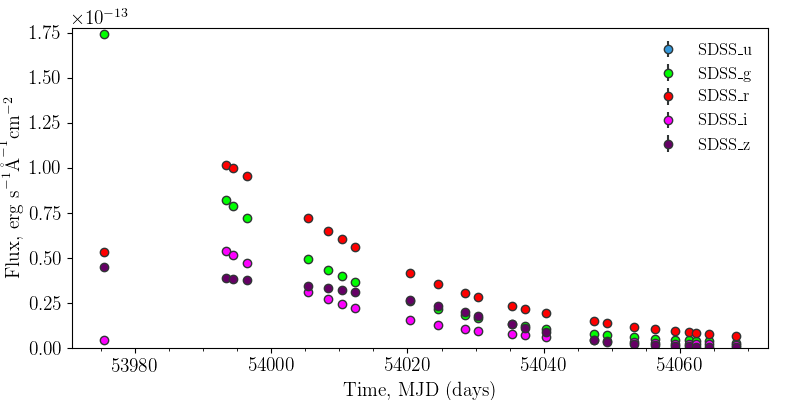

           MJD          flux  flux_err  filter         zp
0    53975.375  1.743854e-13       0.0  SDSS_g  20.754191
1    53975.375  4.361197e-15       0.0  SDSS_i  21.780146
2    53975.375  5.311742e-14       0.0  SDSS_r  21.355182
3    53975.375           NaN       0.0  SDSS_u  20.064677
4    53975.375  4.504165e-14       0.0  SDSS_z  22.148282
5    53993.387  8.230632e-14       0.0  SDSS_g  20.754191
6    53993.387  5.410360e-14       0.0  SDSS_i  21.780146
7    53993.387  1.016694e-13       0.0  SDSS_r  21.355182
8    53993.387           NaN       0.0  SDSS_u  20.064677
9    53993.387  3.870057e-14       0.0  SDSS_z  22.148282
10   53994.398  7.886992e-14       0.0  SDSS_g  20.754191
11   53994.398  5.174212e-14       0.0  SDSS_i  21.780146
12   53994.398  9.991140e-14       0.0  SDSS_r  21.355182
13   53994.398           NaN       0.0  SDSS_u  20.064677
14   53994.398  3.835045e-14       0.0  SDSS_z  22.148282
15   53996.383  7.252334e-14       0.0  SDSS_g  20.754191
16   53996.383

/Users/berto/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


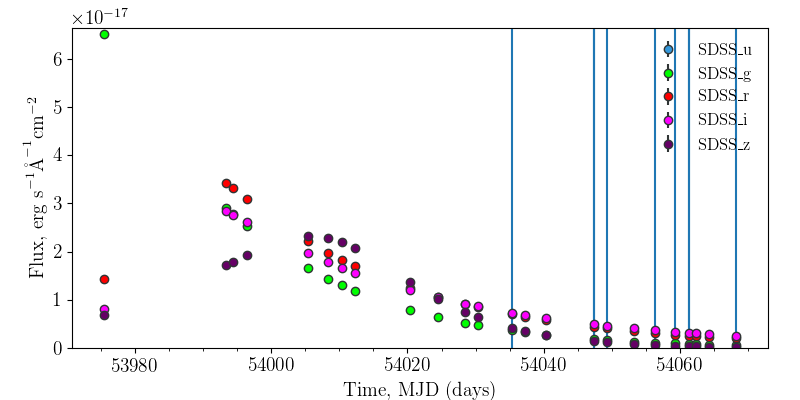

           MJD          flux  flux_err  filter         zp
0    53975.375  6.506233e-17       0.0  SDSS_g  20.754191
1    53975.375  8.018393e-18       0.0  SDSS_i  21.780146
2    53975.375  1.434860e-17       0.0  SDSS_r  21.355182
3    53975.375           NaN       0.0  SDSS_u  20.064677
4    53975.375  6.834450e-18       0.0  SDSS_z  22.148282
5    53993.387  2.911002e-17       0.0  SDSS_g  20.754191
6    53993.387  2.840627e-17       0.0  SDSS_i  21.780146
7    53993.387  3.423886e-17       0.0  SDSS_r  21.355182
8    53993.387           NaN       0.0  SDSS_u  20.064677
9    53993.387  1.711191e-17       0.0  SDSS_z  22.148282
10   53994.398  2.778968e-17       0.0  SDSS_g  20.754191
11   53994.398  2.765679e-17       0.0  SDSS_i  21.780146
12   53994.398  3.313492e-17       0.0  SDSS_r  21.355182
13   53994.398           NaN       0.0  SDSS_u  20.064677
14   53994.398  1.784482e-17       0.0  SDSS_z  22.148282
15   53996.383  2.535779e-17       0.0  SDSS_g  20.754191
16   53996.383

<IPython.core.display.Javascript object>


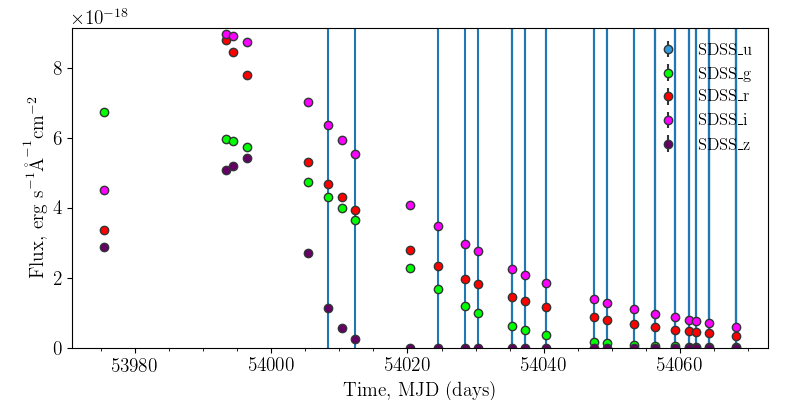

           MJD          flux  flux_err  filter         zp
0    53975.375  6.747142e-18       0.0  SDSS_g  20.754191
1    53975.375  4.507629e-18       0.0  SDSS_i  21.780146
2    53975.375  3.379908e-18       0.0  SDSS_r  21.355182
3    53975.375           NaN       0.0  SDSS_u  20.064677
4    53975.375  2.892999e-18       0.0  SDSS_z  22.148282
5    53993.387  5.967758e-18       0.0  SDSS_g  20.754191
6    53993.387  8.953957e-18       0.0  SDSS_i  21.780146
7    53993.387  8.782946e-18       0.0  SDSS_r  21.355182
8    53993.387           NaN       0.0  SDSS_u  20.064677
9    53993.387  5.070904e-18       0.0  SDSS_z  22.148282
10   53994.398  5.895599e-18       0.0  SDSS_g  20.754191
11   53994.398  8.906836e-18       0.0  SDSS_i  21.780146
12   53994.398  8.443541e-18       0.0  SDSS_r  21.355182
13   53994.398           NaN       0.0  SDSS_u  20.064677
14   53994.398  5.207816e-18       0.0  SDSS_z  22.148282
15   53996.383  5.739653e-18       0.0  SDSS_g  20.754191
16   53996.383

<IPython.core.display.Javascript object>


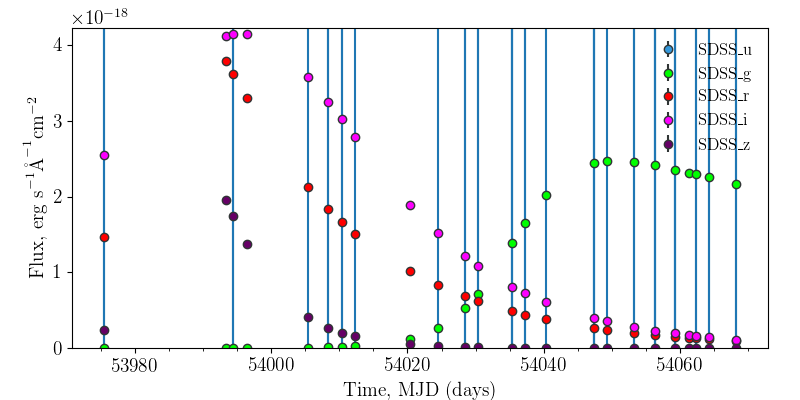

           MJD          flux  flux_err  filter         zp
0    53975.375  1.635819e-23       0.0  SDSS_g  20.754191
1    53975.375  2.553610e-18       0.0  SDSS_i  21.780146
2    53975.375  1.461938e-18       0.0  SDSS_r  21.355182
3    53975.375           NaN       0.0  SDSS_u  20.064677
4    53975.375  2.426575e-19       0.0  SDSS_z  22.148282
5    53993.387  5.910364e-22       0.0  SDSS_g  20.754191
6    53993.387  4.122984e-18       0.0  SDSS_i  21.780146
7    53993.387  3.796610e-18       0.0  SDSS_r  21.355182
8    53993.387           NaN       0.0  SDSS_u  20.064677
9    53993.387  1.953322e-18       0.0  SDSS_z  22.148282
10   53994.398  7.228476e-22       0.0  SDSS_g  20.754191
11   53994.398  4.142123e-18       0.0  SDSS_i  21.780146
12   53994.398  3.624342e-18       0.0  SDSS_r  21.355182
13   53994.398           NaN       0.0  SDSS_u  20.064677
14   53994.398  1.748060e-18       0.0  SDSS_z  22.148282
15   53996.383  1.073253e-21       0.0  SDSS_g  20.754191
16   53996.383

<IPython.core.display.Javascript object>


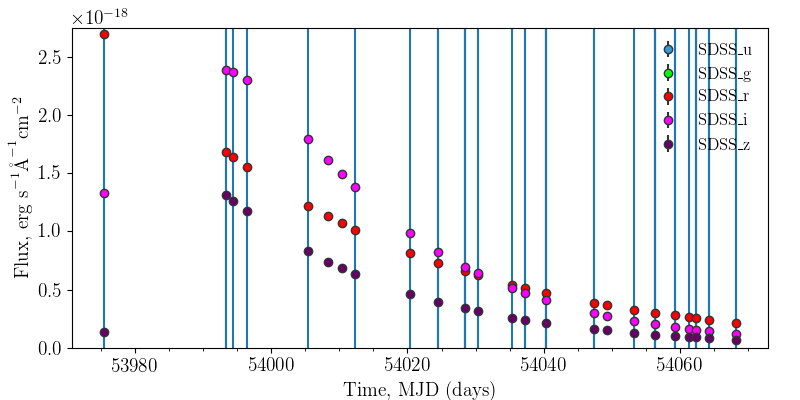

           MJD          flux  flux_err  filter         zp
0    53975.375           NaN       0.0  SDSS_g  20.754191
1    53975.375  1.333108e-18       0.0  SDSS_i  21.780146
2    53975.375  2.691718e-18       0.0  SDSS_r  21.355182
3    53975.375           NaN       0.0  SDSS_u  20.064677
4    53975.375  1.376404e-19       0.0  SDSS_z  22.148282
5    53993.387           NaN       0.0  SDSS_g  20.754191
6    53993.387  2.388367e-18       0.0  SDSS_i  21.780146
7    53993.387  1.681208e-18       0.0  SDSS_r  21.355182
8    53993.387           NaN       0.0  SDSS_u  20.064677
9    53993.387  1.311175e-18       0.0  SDSS_z  22.148282
10   53994.398           NaN       0.0  SDSS_g  20.754191
11   53994.398  2.366567e-18       0.0  SDSS_i  21.780146
12   53994.398  1.636955e-18       0.0  SDSS_r  21.355182
13   53994.398           NaN       0.0  SDSS_u  20.064677
14   53994.398  1.263437e-18       0.0  SDSS_z  22.148282
15   53996.383           NaN       0.0  SDSS_g  20.754191
16   53996.383

<IPython.core.display.Javascript object>


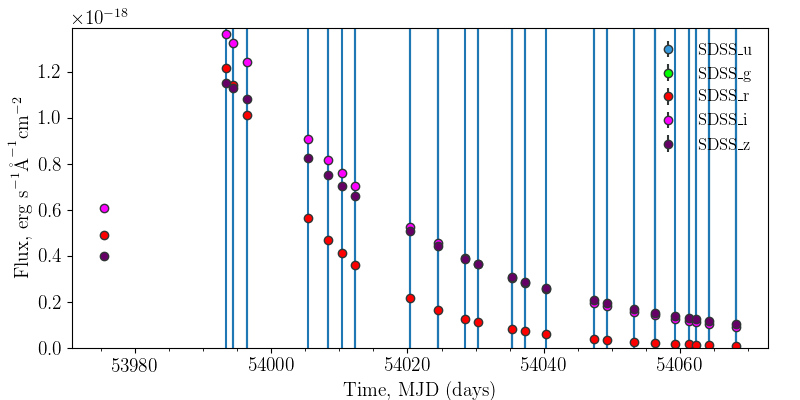

           MJD          flux  flux_err  filter         zp
0    53975.375           NaN       0.0  SDSS_g  20.754191
1    53975.375  6.070047e-19       0.0  SDSS_i  21.780146
2    53975.375  4.894648e-19       0.0  SDSS_r  21.355182
3    53975.375           NaN       0.0  SDSS_u  20.064677
4    53975.375  3.999411e-19       0.0  SDSS_z  22.148282
5    53993.387           NaN       0.0  SDSS_g  20.754191
6    53993.387  1.362181e-18       0.0  SDSS_i  21.780146
7    53993.387  1.216440e-18       0.0  SDSS_r  21.355182
8    53993.387           NaN       0.0  SDSS_u  20.064677
9    53993.387  1.152775e-18       0.0  SDSS_z  22.148282
10   53994.398           NaN       0.0  SDSS_g  20.754191
11   53994.398  1.322734e-18       0.0  SDSS_i  21.780146
12   53994.398  1.143339e-18       0.0  SDSS_r  21.355182
13   53994.398           NaN       0.0  SDSS_u  20.064677
14   53994.398  1.130708e-18       0.0  SDSS_z  22.148282
15   53996.383           NaN       0.0  SDSS_g  20.754191
16   53996.383

<IPython.core.display.Javascript object>


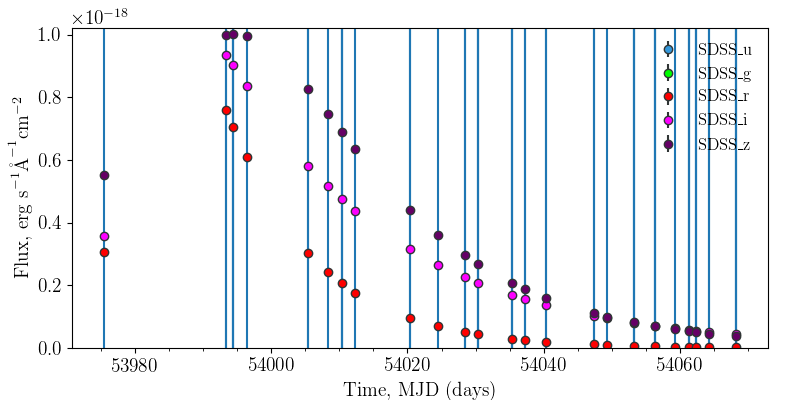

           MJD          flux  flux_err  filter         zp
0    53975.375           NaN       0.0  SDSS_g  20.754191
1    53975.375  3.571631e-19       0.0  SDSS_i  21.780146
2    53975.375  3.067071e-19       0.0  SDSS_r  21.355182
3    53975.375           NaN       0.0  SDSS_u  20.064677
4    53975.375  5.509671e-19       0.0  SDSS_z  22.148282
5    53993.387           NaN       0.0  SDSS_g  20.754191
6    53993.387  9.350787e-19       0.0  SDSS_i  21.780146
7    53993.387  7.606266e-19       0.0  SDSS_r  21.355182
8    53993.387           NaN       0.0  SDSS_u  20.064677
9    53993.387  9.997431e-19       0.0  SDSS_z  22.148282
10   53994.398           NaN       0.0  SDSS_g  20.754191
11   53994.398  9.021131e-19       0.0  SDSS_i  21.780146
12   53994.398  7.062365e-19       0.0  SDSS_r  21.355182
13   53994.398           NaN       0.0  SDSS_u  20.064677
14   53994.398  1.001736e-18       0.0  SDSS_z  22.148282
15   53996.383           NaN       0.0  SDSS_g  20.754191
16   53996.383

In [16]:
stepsize = 0.05
plot = True
for z_sim in np.arange(0.001, z_max+stepsize,stepsize):
    if log:
        logpath = logfile + str(n_sne+1).rjust(6, "0") +".json"
        
        # snname = b"SN2011dh"
        # mag_offset = -2.0 ## Make Ia-like
        ## Simulate "Perfect" LC
        flux, flux_err = coco.simulate(snname,
                                       z_sim, mag_offset, MW_EBV, host_EBV, 3.1,
                                       mjdmax, mjd_to_sim,
                                       filters_to_sim)
        #
        # flux, flux_err = coco.simulate(snname,
        #                                z_obs, 0.0, 0.0, 0.0, 3.1,
        #                                mjdmax, mjd_to_sim,
        #                                filters_to_sim)
#         print(flux)
        p = pcc.PhotometryClass()
        p.load_table(pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim), verbose=False)
        if plot: p.plot(enforce_zero=True)

        ## calculate zeropoints and convert to mag
        p_df = p.phot.to_pandas()
        p_df["zp"] = p_df["filter"].map(zp_dict)
        if verbose: print(p_df)
        p_df["mag"] = -2.5 * np.log10(p_df.flux) - p_df.zp

        ## Add noise - returns units of
        flux, flux_err = lcs.simulate(p_df["mag"], obslog, unit="ab")

        if plot:
            plt.errorbar(p_df.MJD, flux, yerr=flux_err, fmt="o")
            plt.show()

        w_detected = np.where((~np.isnan(flux.values)) & ((flux.values/flux_err.values) > 5))[0]
        # if verbose:
        if verbose:
            print("Flux, Flux_err")
            print(flux, flux_err)
        if verbose:
            print("where detected, len")
            print(w_detected, len(w_detected))


        if verbose: print("good sne")
        ## Remove redshift simulated at top of code from the list
        # z_obs = np.delete(z_obs, [w_z])

        p_df["flux"] = flux
        p_df["flux_err"] = flux_err
        p_df["#MJD"] = p_df["MJD"]
        p_df.fillna(0, inplace = True)
        full_out_path = outfile + str(z_sim).rjust(6, "0") + ".dat"
        p_df[["#MJD", "flux", "flux_err", "filter"]].to_csv(full_out_path, sep=" ", index = False, )

        if log:
            logdict = {}
            for i in logvars:
                if type(locals()[i]) == np.ndarray:
                    logdict[i] = locals()[i].tolist()
                elif type(locals()[i]) == np.int64:
                    logdict[i] = int(locals()[i])
                elif type(locals()[i]) == pd.Series:
                    logdict[i] = locals()[i].to_json()
                elif type(locals()[i]) == bytes:
                    logdict[i] = str(locals()[i], "utf-8")
                else:
                    logdict[i] = locals()[i]

            with open(logpath, "w") as ofile:
                json.dumps(logdict, sort_keys=True,
                           indent=4, separators=(',', ': '))
                #     for i in logvars:
                json.dump(logdict, ofile, sort_keys=True,
                          indent=4, separators=(',', ': '))

            #         ofile.write(str(i) + " " + str(locals()[i]) + "\n")
                ofile.close()


In [ ]:
p_df

In [ ]:
-2.5 * np.log10(p_df.flux) - p_df.zp

Load in an templates object 